# To Tree or Not to Tree

The obective of this project was to create a tool that would help automate the identification of fuels and fuel loads which can cause pyrolosis to homes and key structures on a property.   

Problem Statement:  
    1) According to Verisk Risk Assessors 2018 fire risk remains significant. 4.5 million U.S. homes were identified at high or extreme risk of wildfire, with more than 2 million in California alone.  Montana and Idaho have the highest percentage of households in these risk groups, and Colorado ranks third in number and percentage of homes at risk.  Washington ranked 7th in number of homes at high or extreme risk.
    2) Who's dealing with this currently (or who's not) currently, in Washington the WA State dept of fish and wildlife is conducting Rx burns on the Okagagan district. Not FS, BIA, nor BLM.   
    Kaggle has a competition about predicting the cause of wildfires in CA. All due credit to kaggle for bringing in new minds, but whether cigarettes, camp fires, or lightening causes them, its the fuels the make them bad.  
    

# Notebook Sections

- [Import Statements](#imports)    
- [Creating an Image Dataset](#scrape)
- [Image Prossessing](#prep)  
- [Model](#model)         
- [Results](#results)       
- [Images from Google Streetview](#streetview)  
- [Fire Risk to Key Structures](#risk)
    

<a id='imports'></a>
# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.optimizers import Adam, Adamax, Nadam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imutils import paths

import argparse
import random
import cv2
print("OpenCv version : %s " % cv2.__version__)
import os

import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Couldn't import dot_parser, loading of dot files will not be possible.


OpenCv version : 3.4.0 


<a id='scrape'></a>
# Creating an image dataset
## This is a binary classification of Trees and anything else (not-trees)
## "Just so long as dont have to scrape websites...."

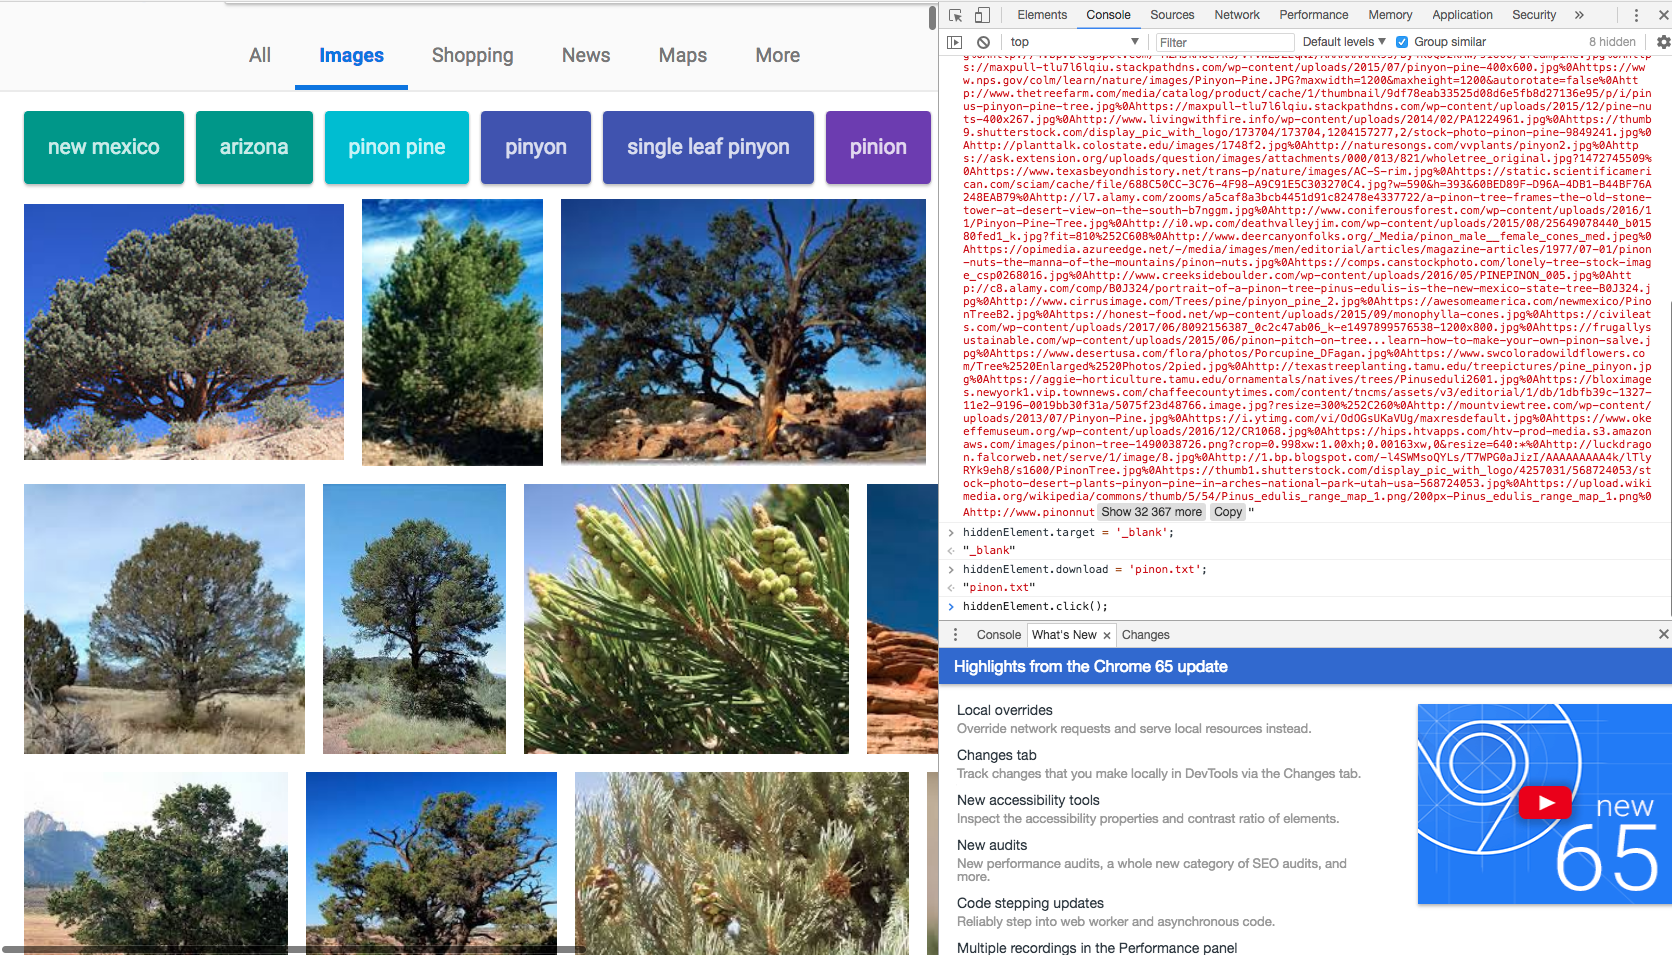

### This process created a nice long list of images urls that looked like the one below

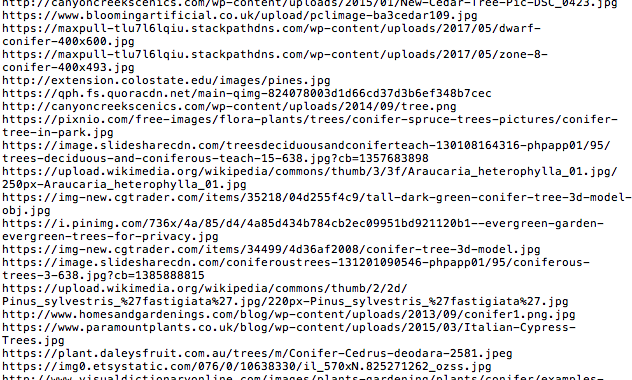

 ### Datasets of Trees and Not Trees     (2000 of each)

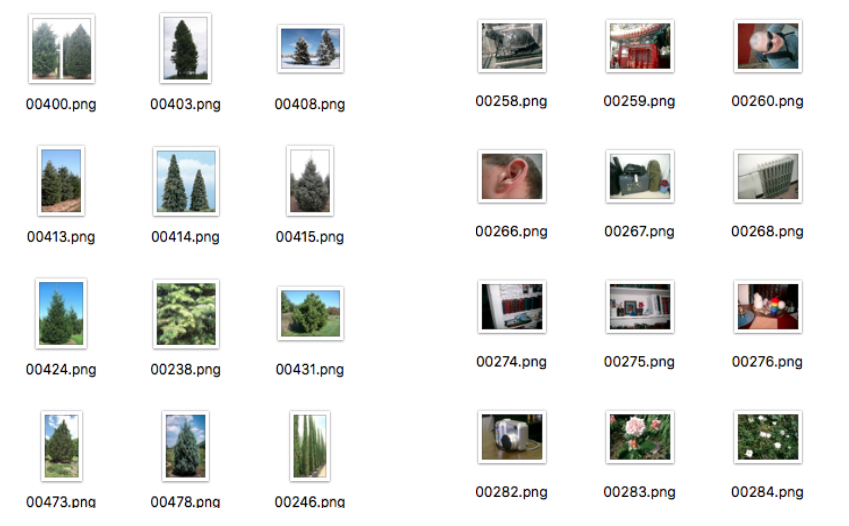

<a id='prep'></a>

# Image Processing

#### Because image data is so large, memory becomes an issue quickly.  Therefore we have to loop through the images, pulling in one at a time to process.

In [4]:
#  BEFORE RUNNING THIS CELL: 1) Randomizing leads to better model performance but it will throw off 
    # the image examples I have used below.
    # 2)  Remove the loss/accuracy chart from the folder or it will be pulled into the model

data = []       # Images 
labels = []     # labels are extracted from the path.  2 separate folders titled tree and not_tree.

# As part of the Docker environment (as confirmed by Dave) paths dont work normally.  
    # Therefore, I'm simply pulling the images out of this folder.
    
imagePaths = sorted(list(paths.list_images("./")))

# # randomize the order that these images are used
# random.seed(42)                    
# random.shuffle(imagePaths)

for imagePath in imagePaths:          
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))  
    image = img_to_array(image)
    
    data.append(image)    

    label = imagePath.split(os.path.sep)[-2]
    label = 1 if label == 'tree' else 0
    labels.append(label)

#### While the model will run and "work" with uneven amounts of data in each category, it's performance is not as robust as that may sound.  To get proper (much better) performance, the number of images in each category need to be equal.

In [5]:
# If label 0 has 2001 images, its probably the loss/accuracy chart.   
# Remove that from the directory, re-run imagePaths cell and continue.

image_df = pd.DataFrame(list(zip(data, labels)), columns=["image", "label"])
image_df.label.value_counts()

1    2000
0    2000
Name: label, dtype: int64

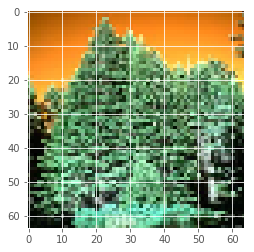

In [86]:
plt.imshow(data[3897])

#### Next we need to scale the data.  Since these are color images, we need to scale according to the RBG spectrum of 256 colors (0-255).

In [37]:
data = np.array(data, dtype="float")
data = data/255.0
labels = np.array(labels)

#### Split our image data into training and testing (or validation) sets. 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42) 

#### Next I use to_categorical to fix the issue of both tree (not-tree(1,0)) being in the same column

In [39]:
y_train = to_categorical(y_train, num_classes=2)
y_test  = to_categorical(y_test, num_classes=2)

#### Image Data Generator

This is a tool that Keras provides which helps us "generate batches of tensor image data with real-time data augmentation."  Since this was a new tool for me, I'll provide a quick overview/explaination of my choices.  A short guide of the features I've used is:  
Rotation Range  
Since I'm using images collected from random photos, there is no standard for direction or angle.  Therefore, in order to standardize the range of information the model examines, this tool creates new image data by randomly rotating the images in the original dataset (in this case up to 30 degrees).  
Shifts Range  
Again, since I am using images from the wild, I have no control over trees being centered, and even if I did, I would want the model to be able to identify trees that were off-center or even off in a corner.  Using the horizontal and vertical shift ranges allows the model to create off center image data, and learn from that.   
Shear Range  
The effect of shear mapping is to displace every point horizontally by an amount proportionally to its y coordinate.  This is something like rotation, however, rotating an image maintains distance between points on the image, while shearing does not.  If the shear 'size' is too large the image become very distorted.   
Zoom range  
This magnifies and crops an image, 'zooming in' on a part of the image just like one mind with a zoom lense.   
Random Flips  
While this tool supports randomly flipping images both vertically and horizontally, flipping vertically would result in an upside down tree which would not be helpful.  So I only used horizontal flipping.  
Fill Mode  
If the model tries to examine points outside the boundaries of the image, fill mode 'imputes' in those points in different ways.  Here I have the model use the nearest point on the image to fill in the values.    


In [40]:
# Augmentation
aug= ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

<a id='model'></a>

# Model Build, Fit, and Run

#### Building the model

In [41]:
model = Sequential()
inputShape = (64, 64, 3)
classes = 2

# Pooling layer 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=inputShape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

# Pooling layer 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

# Pooling layer 3
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.20))

# Flattening layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))

# Softmax layer
model.add(Dense(classes, activation='softmax'))
     

#### Compiling the model. 

#### Learning rate is very important to the loss function.  0.1 is quick and dirty, but smaller numbers yeild better performance.  After some trial and error I settled on 0.001.  
#### While I started out using formulas to schedual learning rate decay, I discovered that Adam's default decay rate worked just as well.

In [42]:
INIT_LR = 0.001                
EPOCHS  = 10                   

# Other variations of optimizers that I tried were Nadam, and Adamax.  I stuck with Adam
opti= Adam(lr=INIT_LR) 
model.compile(loss='binary_crossentropy', optimizer= opti, metrics=['accuracy'])


#### Next I trained my neural network.
####  Initially, after running the fit_generator to implement the image date generator, I then fit my model.  Having done that on 100 epochs, I saved the weights learned by the model during that run, and now I can simply re-use those weights and run far fewer epochs which saves time and still produces reasonable performance.


In [43]:
H = model.fit_generator(aug.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) // 32, validation_data=(X_test, y_test), epochs=EPOCHS, verbose=1)

#model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=1)
model.load_weights("my_model_weights.h5")


Epoch 1/10
93/93 [==============================] - 72s 777ms/step - loss: 0.4910 - acc: 0.7628 - val_loss: 0.3911 - val_acc: 0.8890
Epoch 2/10
93/93 [==============================] - 66s 705ms/step - loss: 0.3065 - acc: 0.8833 - val_loss: 0.2331 - val_acc: 0.9240
Epoch 3/10
93/93 [==============================] - 66s 708ms/step - loss: 0.2657 - acc: 0.8910 - val_loss: 0.3347 - val_acc: 0.8570
Epoch 4/10
93/93 [==============================] - 66s 712ms/step - loss: 0.2323 - acc: 0.9048 - val_loss: 0.2036 - val_acc: 0.9190
Epoch 5/10
93/93 [==============================] - 66s 706ms/step - loss: 0.2214 - acc: 0.9112 - val_loss: 0.1771 - val_acc: 0.9250
Epoch 6/10
93/93 [==============================] - 65s 703ms/step - loss: 0.2262 - acc: 0.9139 - val_loss: 0.3842 - val_acc: 0.8360
Epoch 7/10
93/93 [==============================] - 66s 706ms/step - loss: 0.1845 - acc: 0.9263 - val_loss: 0.2239 - val_acc: 0.9060
Epoch 8/10
93/93 [==============================] - 68s 728ms/step - 

In [ ]:
# model.save_weights('my_model_weights.h5')

<a id='results'></a>

# Results

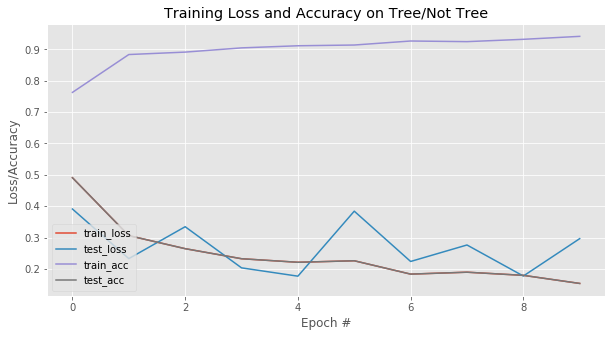

In [45]:
# April 9th 10:30am with model build using 2 conv2d, then Maxpool, then Dropout in each layer
# INIT_LR = 0.001                
# EPOCHS  = 10   

# Plotting the results (loss and accuracy for the training set)
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
n = EPOCHS
plt.plot(np.arange(0, n), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, n), H.history['val_loss'], label='test_loss')
plt.plot(np.arange(0, n), H.history['acc'], label='train_acc')
plt.plot(np.arange(0, n), H.history['loss'], label='test_acc')
plt.title('Training Loss and Accuracy on Tree/Not Tree')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig('training_loss_acc')

#### Training the model with 100 epochs and a learning rate of 0.001

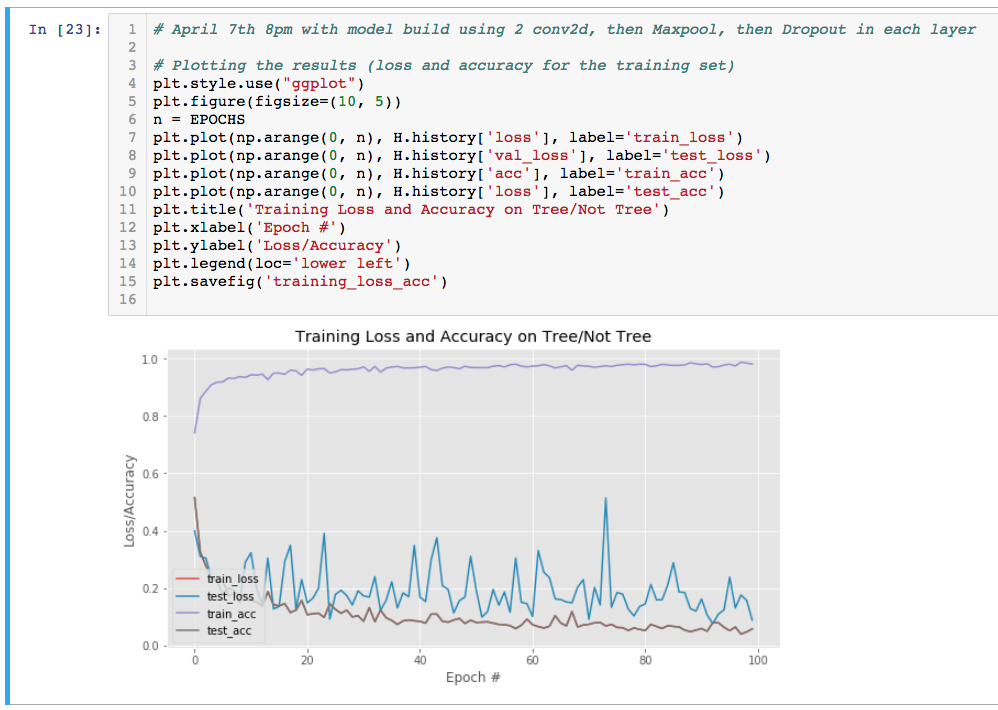

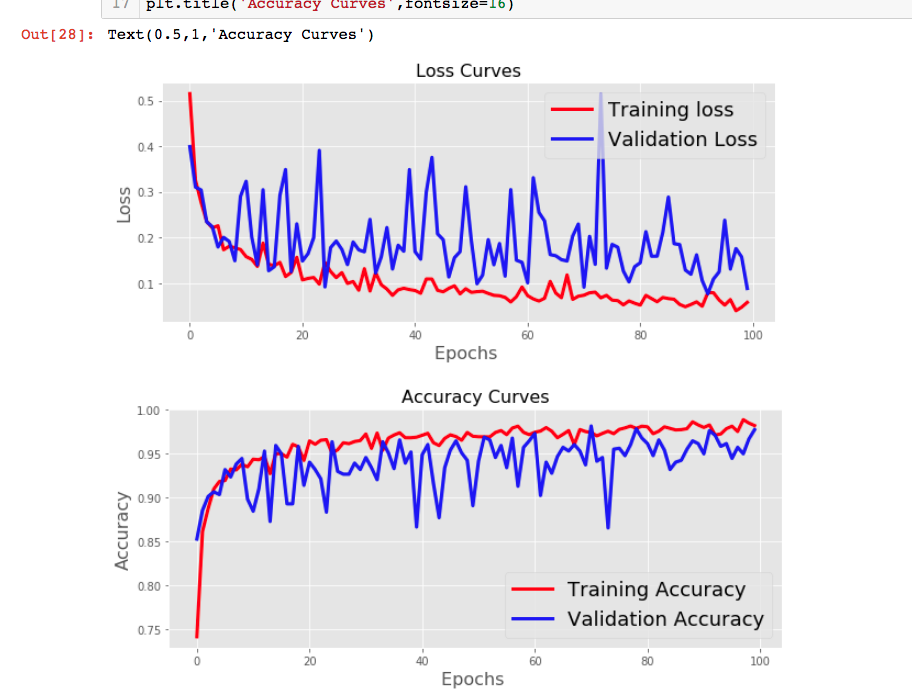

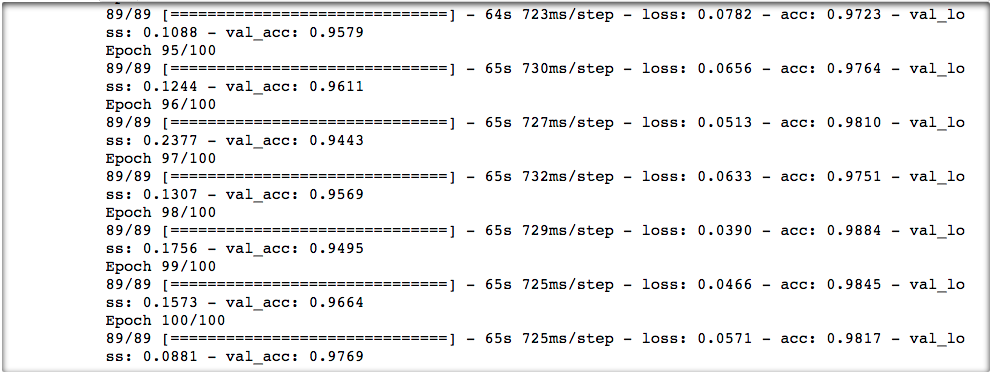

In [44]:
accuracy = model.evaluate(x=X_test,y=y_test,batch_size=32)
print("Accuracy: ",accuracy[1])

1000/1000 [==============================] - 6s 6ms/step
Accuracy:  0.984


#### Lets actually see the results

In [59]:
model.predict_proba(X_test)

array([[9.9986959e-01, 1.3041603e-04],
       [1.9504715e-04, 9.9980503e-01],
       [9.9999285e-01, 7.1289646e-06],
       ...,
       [9.9979562e-01, 2.0445643e-04],
       [1.0000000e+00, 4.1478987e-11],
       [1.1006209e-06, 9.9999893e-01]], dtype=float32)

In [70]:
img = X_test[456]
test_img = img.reshape((1, 64, 64, 3))
img_class = model.predict_classes(test_img)    
prediction = img_class[0]
classname = img_class[0]
print("Class: ",classname)

Class:  0


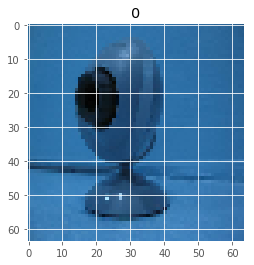

In [71]:
img = img.reshape((64, 64, 3))
plt.imshow(img)
plt.title(classname)
plt.show()

#### Clearly, not a tree.  Model classified this first thing correctly.


In [60]:
img = X_test[317]
test_img = img.reshape((1, 64, 64, 3))
img_class = model.predict_classes(test_img)    
prediction = img_class[0]
classname = img_class[0]
print("Class: ",classname)

Class:  1


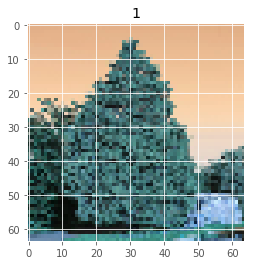

In [61]:
img = img.reshape((64, 64, 3))
plt.imshow(img)
plt.title(classname)
plt.show()

#### Clearly this is a tree.  Model classified this correctly as well.

#### Time for some images from the mean streets of Twisp, WA.

<a id='streetview'></a>

# Trees in the Wild (Images from Google Streetview)

#### Now we need to introduce a new image from google street view.  

In [62]:
img = cv2.imread('./images/tree/02000.png')
img = cv2.resize(img, (64, 64))
#img = X_test[907]
test_img = img.reshape((1, 64, 64, 3))
img_class = model.predict_classes(test_img)    
prediction = img_class[0]
classname = img_class[0]
print("Class: ", classname)

Class:  1


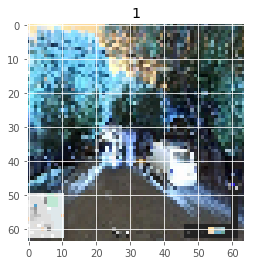

In [63]:
img = img.reshape((64, 64, 3))
plt.imshow(img)
plt.title(classname)
plt.show()

Actual image -- House #1

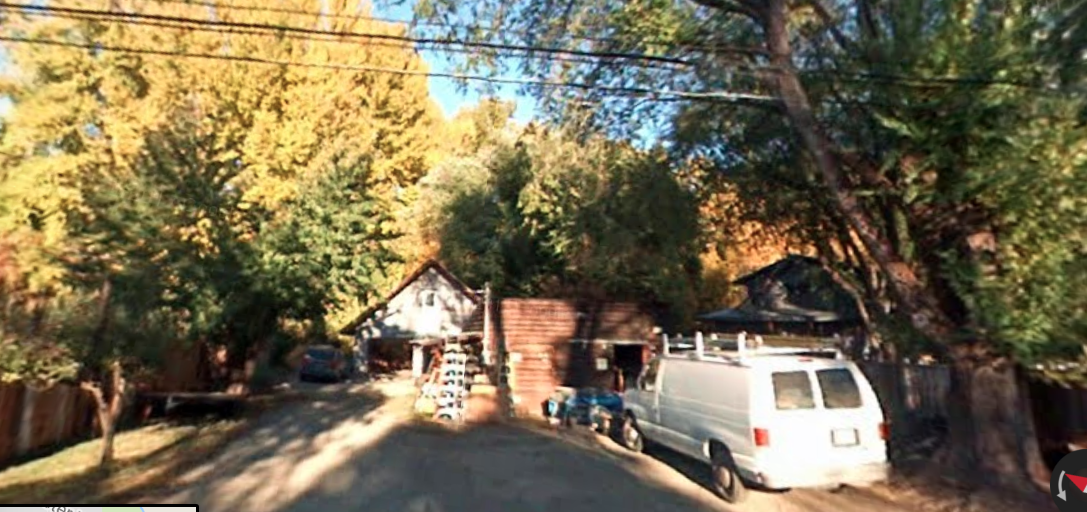

In [64]:
img = cv2.imread('./images/tree/02001.png')
img = cv2.resize(img, (64, 64))
#img = X_test[907]
test_img = img.reshape((1, 64, 64, 3))
img_class = model.predict_classes(test_img)    
prediction = img_class[0]
classname = img_class[0]
print("Class: ", classname)

Class:  1


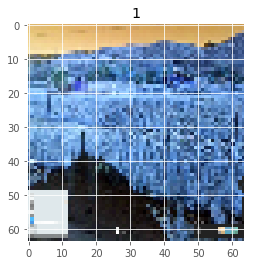

In [65]:
img = img.reshape((64, 64, 3))
plt.imshow(img)
plt.title(classname)
plt.show()

Actual image -- House #2

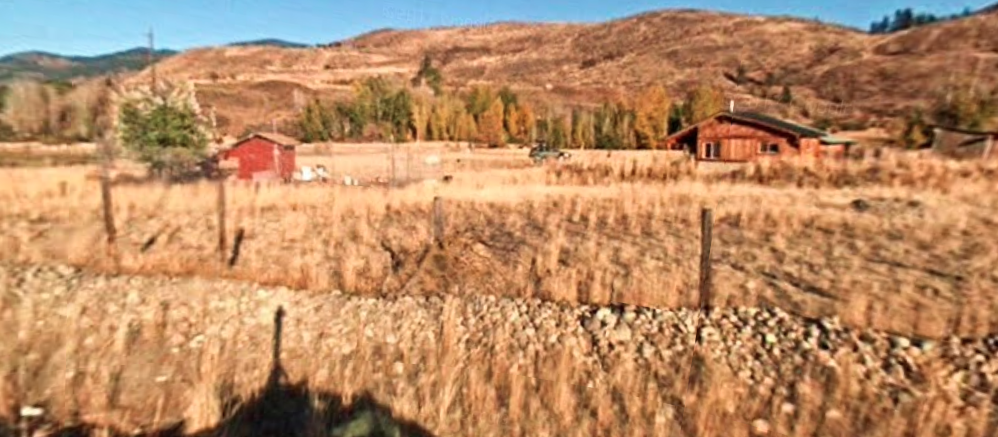

In [66]:
img = cv2.imread('./images/tree/02002.png')
img = cv2.resize(img, (64, 64))
#img = X_test[907]
test_img = img.reshape((1, 64, 64, 3))
img_class = model.predict_classes(test_img)    
prediction = img_class[0]
classname = img_class[0]
print("Class: ", classname)

Class:  1


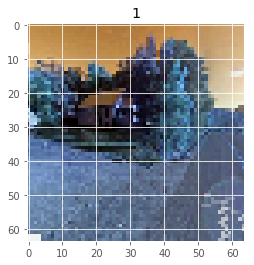

In [67]:
img = img.reshape((64, 64, 3))
plt.imshow(img)
plt.title(classname)
plt.show()

Actual image  -- House #3

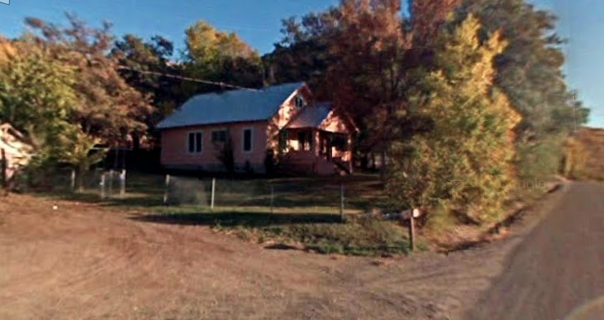

<a id='risk'></a>

# Fire Risk to Key Structures

#### Houses one and three will obviously be destroyed, but what about house number two?

#### Examining radiant energy starts with how much fuel there is to burn.  The information on Bulk Density here, lines up very nicely with the bulk density numbers from the pyrolosis research 

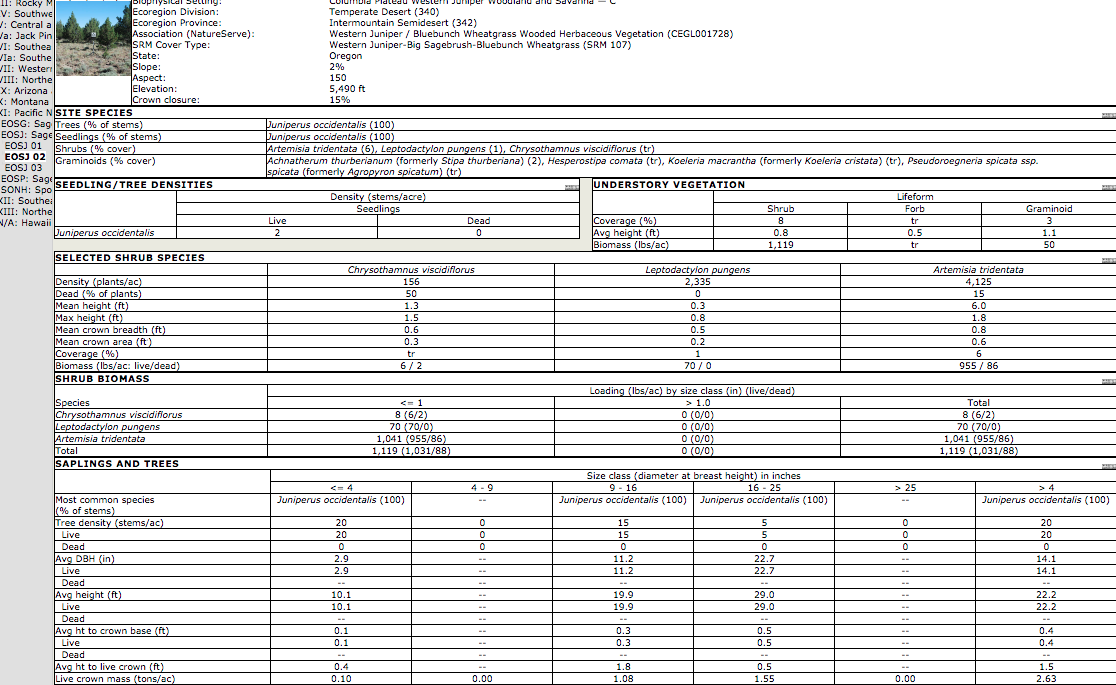

#### The information on bulk density from junipers in sage-grasslands lines up very nicely with the bulk density numbers from the pyrolosis research by Mell, et al., 2009

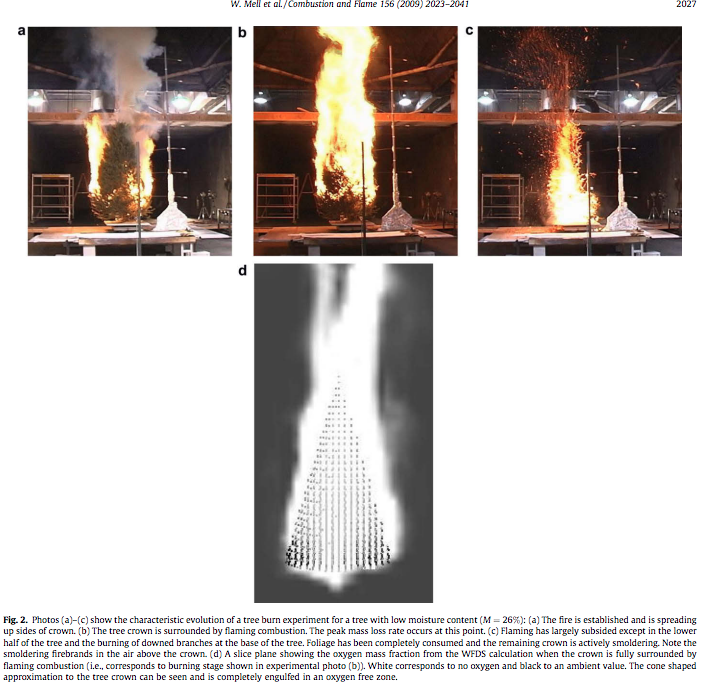

#### Approximating the shed to be roughly 8-10 feet high, the 5 meter high tree data seems appropriate

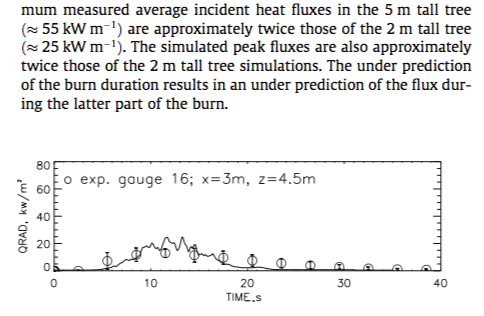

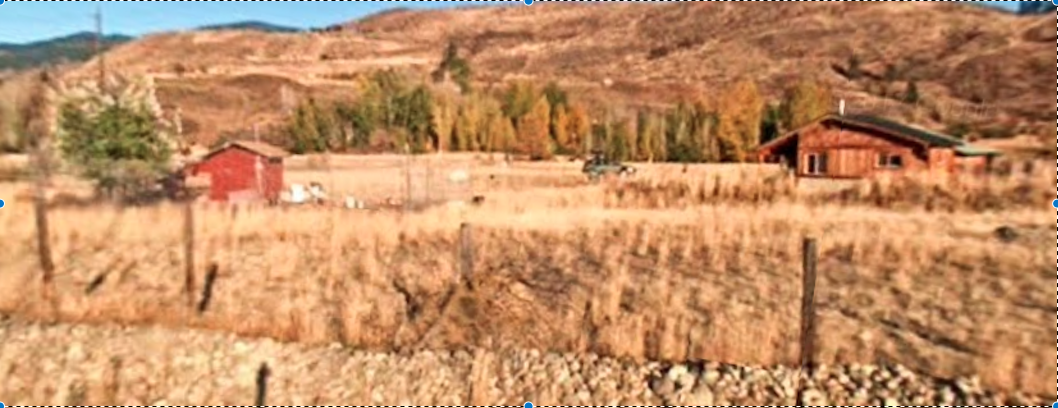

This heat flux at 3 meters (~10 feet) will certainly char, and probably ignite the shed, but the house is considerably further away than 10 feet, and looks well surrounded by defensible space.  
Ten feet is a very typical suggestion for defensible space between trees and a house 
for exactly this reason. 

# Conclusion and Next Steps

There were several stumbling blocks in this process, most notably the collection and preporcessing of the image data.  None-the-less, this work establishes that "drive-by" photography freely available on the web, can be used to flag properties that may or may not have elevated fire risks associated with the key structures on that property.

Further work on this project should create some means of measuring the height of trees or bushes, the distance from key structures, and distance from other trees (continuity of fuels).  Additionally, the area of an image, and the perspective of that image needs to be taken into account.  The angle of the photo (perspective) could change whether the image is flagged as having a tree to close or not.  While the area of the image (crop) can flag trees that not relevant.  Some of this could be addressed with focal point and field of view but that would require a new set of streetview images with different camera equipment (not likely.)  While the home in the image above is actually quite safe.  A high quality image would throw a flag due to the trees in the background.